In [2]:
# Comentario : el código está preparado para correr completo en Google Colab con GPU sin hacer modificaciones. 

## 1. Setup

In [ ]:
# Actualizo librerías necesarias
!pip install -U spacy

# Descargo nuevas librerías
!pip install spacy-universal-sentence-encoder 
!pip install googletrans

# Descargo dataset
!wget -q -O train.csv https://drive.google.com/u/0/uc?id=1SvVbsYUpKphC3NuU4y7JDYsDJxYT61Yl

# Descargo modelo "large" (lg) en español de Spacy
!python -m spacy download es_core_news_lg

## 2. Librerías

In [2]:
import os
import pandas as pd
import numpy as np
import math
import spacy
import spacy_universal_sentence_encoder
import unicodedata
import re
import tqdm
import random
import gc

import googletrans
from googletrans import Translator

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.utils import np_utils
from keras import backend as K 

from wordcloud import WordCloud
from collections import Counter

from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary

import matplotlib.pyplot as plt
%matplotlib inline

## 3. Corpus de mensajes

In [3]:
# Cargo dataset de entrenamiento 
corpus = pd.read_csv('train.csv', sep='|')
corpus.head(5)

,Pregunta,Intencion
0,como puedo trabajar en santander rio,Cat_102
1,pagar tarjeta visa querer reintegro,Cat_350
2,pagar tarjeta naranja sistema,Cat_132
3,no se debitó la primera cuota del plan de bien...,Cat_129
4,abonar tarjeta credito,Cat_342


## 4. Exploración de datos

In [4]:
print('Cantidad de preguntas: ' , corpus.shape[0])

Cantidad de preguntas:  20104


In [5]:
print('Total de clases: ' , len(corpus['Intencion'].unique()))

Total de clases:  352


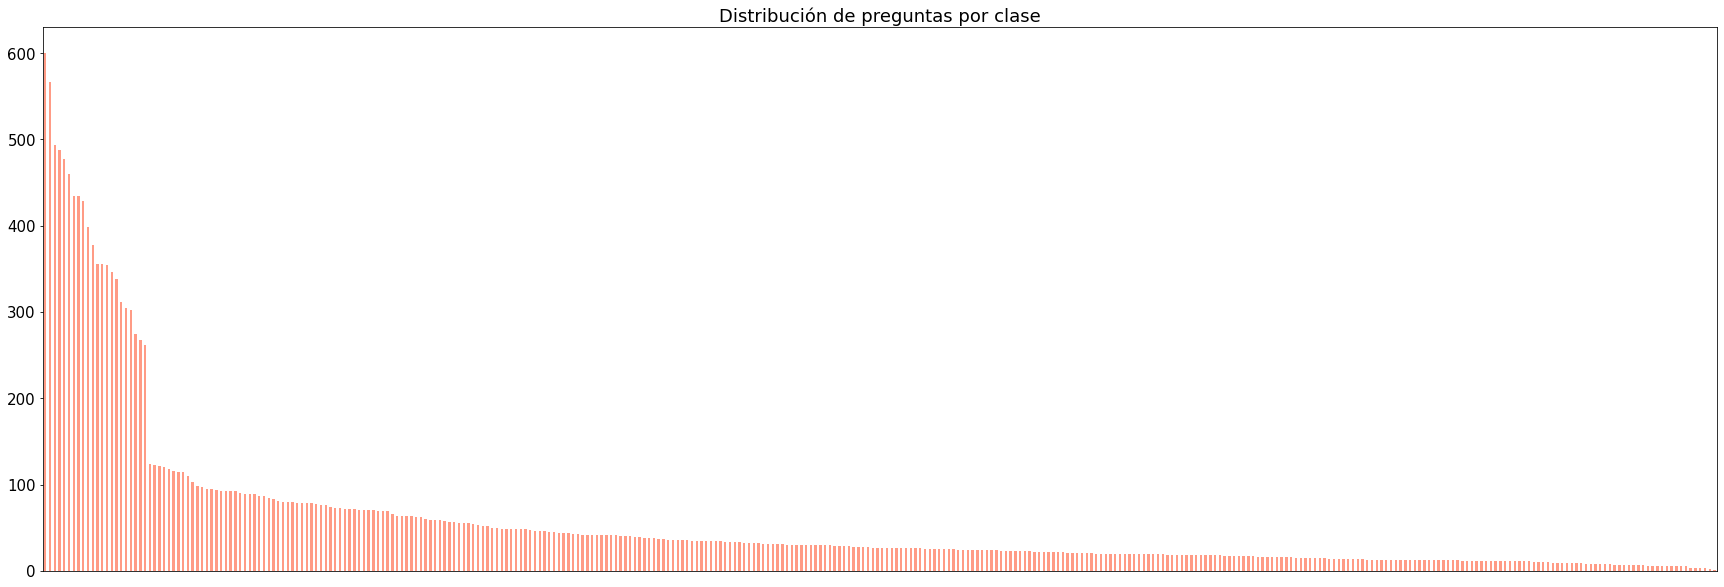

In [6]:
# Cantidad de preguntas por clase
category_freq = corpus['Intencion'].value_counts()
category_freq = pd.DataFrame({'n':  category_freq.values, 
                              'Percentage': category_freq.apply(lambda x: '{0} %'.format(x*100/len(corpus)))})

# Defino fuente de gráficos
plt.rcParams.update({'font.size': 15})

# Gráfico de barras
fig, axes = plt.subplots(figsize=(10, 10), nrows=1, ncols=1)
category_freq['n'].plot(kind='bar', title='Distribución de preguntas por clase', 
                        color="#FF9B85", figsize=(30, 10)).get_xaxis().set_ticks([]);

In [7]:
print('Menor cantidad de preguntas en una clase: ', category_freq['n'].iloc[len(category_freq)-1])

Menor cantidad de preguntas en una clase:  1


In [8]:
print('Mayor cantidad de preguntas en una clase: ', category_freq['n'].iloc[0])

Mayor cantidad de preguntas en una clase:  600


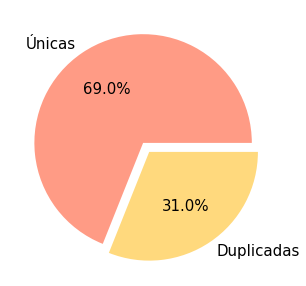

In [9]:
# Preguntas duplicadas
unique_q    = corpus.groupby(["Pregunta", 'Intencion']).filter(lambda x: len(x) == 1)
duplicate_q = corpus.groupby(["Pregunta", 'Intencion']).filter(lambda x: len(x) > 1)

# Gráfico de torta
fig = plt.gcf()
fig.set_size_inches(5,5)
plt.pie((len(unique_q)*100/len(corpus), len(duplicate_q)*100/len(corpus)), labels=['Únicas', 'Duplicadas'], autopct='%1.1f%%', 
        colors =["#FF9B85", "#FFD97D"], explode = (0, 0.1));

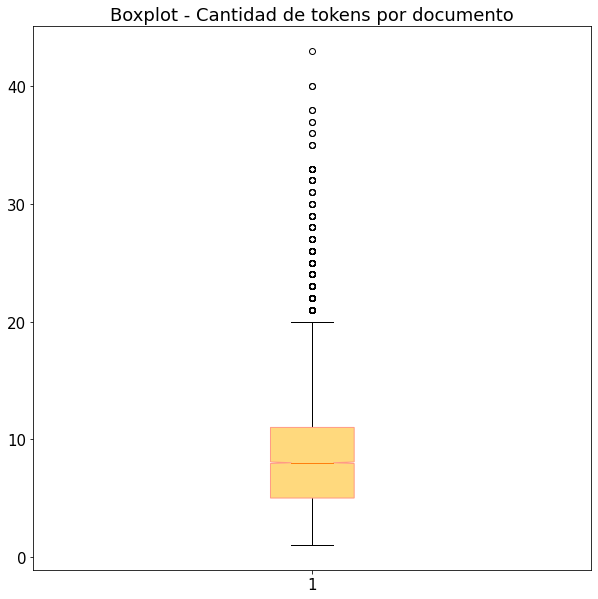

In [10]:
# Cantidad de tokens por documento
cnt_tokens = corpus['Pregunta'].apply(lambda x: len(x.split()))

# Gráfico boxplot
fig, axes = plt.subplots(figsize=(10, 10), nrows=1, ncols=1)

box = plt.boxplot(cnt_tokens, notch=True, patch_artist=True, boxprops=dict(facecolor="#FFD97D", color="#FF9B85"))
axes.set_title('Boxplot - Cantidad de tokens por documento');

In [11]:
# Descripción general
cnt_tokens.describe()

count    20104.000000
mean         8.201253
std          4.409405
min          1.000000
25%          5.000000
50%          8.000000
75%         11.000000
max         43.000000
Name: Pregunta, dtype: float64

Se observa que hay documentos con 1 solo token y el máximo de tokens en un documento es de 43, con un promedio de 8 tokens por mensaje. Se podría decir que aproximadamente la mayoría de los documentos tienen entre 1 (Q1 - 1.5 IQR) a 20 (Q3 + 1.5 IQR) tokens.

## 5. Cargo modelo español Spacy

In [12]:
# Cargo modelo preentrenado de spacy en español
import es_core_news_lg
nlp = es_core_news_lg.load()

# Descargo y cargo modelo multilenguaje para USE vectors
nlp_use = spacy_universal_sentence_encoder.load_model('xx_use_lg')

print(nlp.pipe_names)

Downloaded https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3, Total size: 334.32MB

['tagger', 'parser', 'ner']


## 6. Aumento de datos

La idea es crear nuevos mensajes en base a otros mensajes originales del corpus (por categoría), con leves cambios en el texto pero manteniendo el contexto de las preguntas a través de un proceso de traducciones para que todas las clases tengan como mínimo 6 documentos con el fin de poder evaluar los modelos con train/test o cross-validation de forma estratificada (igual cantidad de clases por fold o proporcional al tamaño de train/test).  

### 6.1. Función de traducción

In [13]:
# Lista de lenguajes disponibles para traducir
lenguaje = ["es", "de", "fr", "ar", "te", "hi", "ja", "fa", "sq", "bg", "nl", "gu", "ig", "kk", "mt", "ps"]

# Función de traducción
def traducir_random(mensaje, lenguaje, aug_range=1):    
    augmented_messages = []

    for j in range(0, aug_range) :
        try:
            # Traduce el mensaje a un idioma elegido aleatoriamente
            mensaje = Translator().translate(mensaje, dest=random.choice(lenguaje)).text 
            # Traduce nuevamente al español
            mensaje_es = Translator().translate(mensaje, dest="es").text
        except:
            mensaje_es = mensaje
        augmented_messages.append(str(mensaje_es))

    return augmented_messages

In [14]:
# Ejemplo de aumentación con 2 traducciones posibles para el mensaje "correo electrónico erroneo"
random.seed(4134)
ejemplo_traduccion = traducir_random("correo electrónico erroneo", lenguaje, 2)
print("--------")
print(ejemplo_traduccion)

--------
['Email incorrecto', 'Email inválido']


### 6.2 Documentos por clase

In [15]:
# Determino la cantidad de mensajes por categoría
intencion_count = corpus.Intencion.value_counts().reset_index()
intencion_count.columns = ['Intencion', 'counts']
intencion_count.head()

,Intencion,counts
0,Cat_132,600
1,Cat_293,567
2,Cat_1,493
3,Cat_147,488
4,Cat_223,477


La categoría "Cant_132" tiene la máxima cantidad de mensajes, 600, mientras que hay categorías con solo 1 mensaje.

In [16]:
# Filtro las categorías con menos de 6 mensajes
mensajes_small = intencion_count.loc[intencion_count['counts'] < 6]
mensajes_small

,Intencion,counts
341,Cat_18,5
342,Cat_213,5
343,Cat_14,5
344,Cat_23,5
345,Cat_8,5
346,Cat_11,3
347,Cat_13,3
348,Cat_205,3
349,Cat_15,3
350,Cat_24,2


In [17]:
# Ahora convierto el dataframe en un diccionario
mensajes_small = mensajes_small.set_index('Intencion')['counts'].to_dict()
mensajes_small

{'Cat_104': 1,
 'Cat_11': 3,
 'Cat_13': 3,
 'Cat_14': 5,
 'Cat_15': 3,
 'Cat_18': 5,
 'Cat_205': 3,
 'Cat_213': 5,
 'Cat_23': 5,
 'Cat_24': 2,
 'Cat_8': 5}

### 6.3 Crear aumentación de documentos

In [18]:
# Cantidad mínima de documentos por clase
AUMENTACION = 6

# Creo un nuevo dataframe
newdf = pd.DataFrame()

# Aumento datos en las categrías con menos de 6 clases
random.seed(4134)
for intencion, count in mensajes_small.items():

    # Si tiene 1 mensaje se crean al menos 5 para llegar a 6 mensajes
    count_dif = AUMENTACION - count
    
    # Cantidad de aumentación de acuerdo a la cantidad existente de mensajes
    # Si hay 2 mensajes, necesito 2 mensajes nuevos por cada mensaje original para llegar a 6 en total
    multiplicacion_count = math.ceil((count_dif)/count) 

    old_message_df = pd.DataFrame()
    new_message_df = pd.DataFrame()
    
    for mensaje in tqdm.tqdm(corpus[corpus["Intencion"] == intencion]["Pregunta"]) :
       
        # Mensajes originales
        originales = pd.DataFrame([mensaje], columns=['Pregunta'])
        originales["Intencion"] = intencion
        old_message_df = old_message_df.append(originales)

        # Nuevos mensajes
        new_messages = traducir_random(mensaje, lenguaje, multiplicacion_count)
        nuevos = pd.DataFrame(new_messages, columns=['Pregunta'])
        nuevos["Intencion"] = intencion
        new_message_df = new_message_df.append(nuevos)

    #  Se unen mensajes originales con nuevos mensajes creados
    newdf = newdf.append([old_message_df,new_message_df])

100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


In [19]:
# Para Cat_15 se crearon 3 nuevos mensajes, es posible que estos mensajes sean similares al original
newdf.loc[newdf['Intencion'] == 'Cat_15']

,Pregunta,Intencion
0,de donde sos originario,Cat_15
0,tu lugar de nacimiento,Cat_15
0,cual es tu nacionalidad?,Cat_15
0,De dónde es usted,Cat_15
0,Tu lugar de nacimiento,Cat_15
0,¿cuál es la nacionalidad?,Cat_15


In [20]:
# Elimino las filas originales del corpus
corpus = corpus[~corpus['Intencion'].isin(list(mensajes_small.keys()))]

# Agrego nuevos mensajes generados (incluidos los originales) al corpus
corpus = corpus.append(newdf)
corpus.shape

(20150, 2)

## 7. Preprocesamiento de texto

### 7.1. Funciones de limpieza

In [21]:
# Función de limpieza inicial
def normalizar_texto(sentencia):
    
    # Texto a minúscula
    sentencia = sentencia.lower()
    
    # Remover tildes
    sentencia = unicodedata.normalize('NFKD', sentencia).encode('ASCII', 'ignore').decode('utf8')
    
    # Remover números
    sentencia = re.sub(r'(|\W)\d+', " ", sentencia)
    
    # Remover símbolos y puntos
    sentencia = re.sub(r'[^\w\s]', " ", sentencia)
    
     # Remover múltiples espacios
    sentencia = re.sub(r' +', " ", sentencia)
    
    return sentencia

In [22]:
# Función para tokenizar y lemmatizar el texto
def tokenizar_texto(sentencia):
    # Tokenizado  
    doc = nlp(sentencia)
    
    # Remover stop words
    doc = [word for word in doc if not word.is_stop]
       
    # Filtrar palabras con longitud menor a 2 carácteres
    doc = [word for word in doc if len(word) > 2]  
   
    # Lemmatizar
    doc = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in doc ]
    
    return doc

### 7.2. Normalizar texto

In [23]:
# Normalizo mensajes 
corpus = (corpus
          .assign(pregunta_normalizado = corpus['Pregunta']
                 .apply(normalizar_texto)
                 )
         )

corpus.iloc[19:24, :]

,Pregunta,Intencion,pregunta_normalizado
19,necesito pedir una reimpresión.que tramite ten...,Cat_316,necesito pedir una reimpresion que tramite ten...
20,donde pago la cuota del prestamo personal?,Cat_239,donde pago la cuota del prestamo personal
21,tengo un atraso en el pago de mi tarjeta,Cat_192,tengo un atraso en el pago de mi tarjeta
22,en que casas de ropa va a haber promo?,Cat_311,en que casas de ropa va a haber promo
23,deseo ver el estado de distribución del plástico,Cat_293,deseo ver el estado de distribucion del plastico


### 7.3. Tokenizar y lemmatizar texto

In [24]:
# Tokenizo el texto normalizado, la salida es una lista de palabras por fila (documento) -> ['necesitar', 'pedir', ...]
corpus = (corpus
          .assign(pregunta_procesado = corpus['pregunta_normalizado']
                 .apply(lambda sentencia : tokenizar_texto(sentencia))
                 )
         )

# Vuelvo a convertir cada lista de tokens en strings para poder procesar tf-idf -> 'necesitar pedir ...'
corpus['pregunta_procesado'] = corpus['pregunta_procesado'].agg(lambda x: ' '.join(map(str, x)))

corpus.iloc[203:208, :]

,Pregunta,Intencion,pregunta_normalizado,pregunta_procesado
204,soy cliente y necesito un prestamo,Cat_223,soy cliente y necesito un prestamo,cliente necesitar prestamo
205,simulador.de prestamo,Cat_251,simulador de prestamo,simulador prestamo
206,quisiera saber sobre creditos personales,Cat_225,quisiera saber sobre creditos personales,querer creditos personal
207,quiero saber cuales son los pagos que hice con...,Cat_279,quiero saber cuales son los pagos que hice con...,querer pago hacer tarjeta credito
208,que es el coeficiente de estabilización de ref...,Cat_107,que es el coeficiente de estabilizacion de ref...,coeficiente estabilizacion referenciar


### 7.4. Gráfico de nubes de palabras

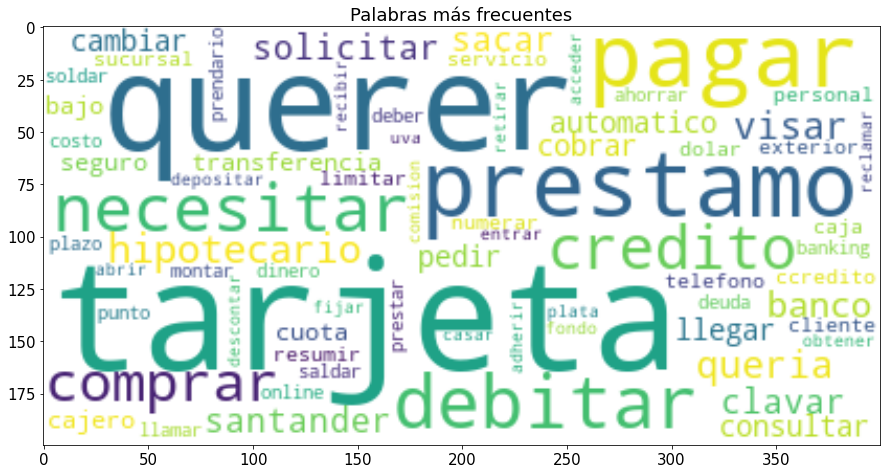

In [25]:
# Tokenizo documentos
doc = nlp
tokens = corpus['pregunta_procesado'].apply(lambda x : [token.text for token in nlp.tokenizer(x)])
dic = Counter()

# Cuento cada palabra del corpus
for tokens in tokens.values:
  dic.update(tokens)

# Crear gráfico de nubes de palabras
def getWordcloud(data):
  return WordCloud(background_color ='white', min_font_size = 8).generate_from_frequencies(data)

wordcloud = getWordcloud(dict(dic.most_common(100)))

fig, axes = plt.subplots(figsize=(15, 10), nrows=1, ncols=1)
axes.imshow(wordcloud, interpolation='bilinear')
axes.title.set_text('Palabras más frecuentes')

## 8. Matriz documento-término con pesos ponderados TF-IDF

In [26]:
# Configuro el método 'TfidfVectorizer', icluye el tokenizador propio ('tokenizar_texto')
tfidfvectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                  min_df = 2, 
                                  max_df = .95)

In [27]:
# Calculo tf-idf sobre texto preprocesado
tfidf = tfidfvectorizer.fit_transform(corpus["pregunta_procesado"])
tfidf

<20150x11047 sparse matrix of type '<class 'numpy.float64'>'
	with 123417 stored elements in Compressed Sparse Row format>

## 9. Clasificación multiclase
Se convierte la matriz tf-idf en un dataframe de 20.150 filas y 11.047 columnas, se divide en train/test y se entrena un modelo sencillo de clasificación para predecir las categorías de las preguntas.

### 9.1. Preparar train / test

In [28]:
random.seed(123)

# Separo clase
df_clase    = corpus.Intencion.astype('category').cat.codes
df_sinclase = tfidf

# Dividio en train y test
train_sinclase, test_sinclase, train_clase, test_clase = train_test_split(
    df_sinclase, df_clase, test_size=0.3, stratify= df_clase, random_state=42
)

### 9.2. Modelo LinearSVC (Modelo 1)

In [29]:
# Modelo LinerSVC
modeloLSVC = LinearSVC()

# Ajusto modelo
modeloLSVC = modeloLSVC.fit(train_sinclase, train_clase, )

# Predicciones en test
prediccionLSVC = modeloLSVC.predict(test_sinclase)

# Calculo Balanced AUC
print(f'Balanced accuracy score: {balanced_accuracy_score(test_clase, prediccionLSVC)}')

Balanced accuracy score: 0.6209052066995292


## 10. Ingeniería de características
Se arma un nuevo dataset compuesto por variables obtenidas haciendo ingeniería de caracterísiticas y se entrena un modelo de clasificación multiclase de redes neuronales. 

### 10.1. Variable con predicciones de un modelo lineal de soporte vectorial
Se crea una variable con predicciones de clases de un modelo LinearSVC. El objetivo es "comprimir" la información de la DTM del modelo 1 en esta variable y combinarla con otras características para enriquecer un nuevo modelo.


In [30]:
# Convierto DTM tf-idf en un dataframe
df_tfidf = pd.DataFrame(tfidf.toarray())
df_tfidf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,11007,11008,11009,11010,11011,11012,11013,11014,11015,11016,11017,11018,11019,11020,11021,11022,11023,11024,11025,11026,11027,11028,11029,11030,11031,11032,11033,11034,11035,11036,11037,11038,11039,11040,11041,11042,11043,11044,11045,11046
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.533824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.640998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
random.seed(123)

# Separo clase
df_clase = pd.DataFrame(corpus.Intencion.astype('category').cat.codes.reset_index(drop=True))
df_clase.columns = ['clase']
df_sinclase = df_tfidf

# Dividio en train / test 
train_sinclase, test_sinclase, train_clase, test_clase = train_test_split(
    df_sinclase, df_clase, test_size=0.3, stratify= df_clase, random_state=42
)

In [32]:
# Función para crear un índice de folds estratificados
def indexFold(y,k):
    
    indice  = list(range(0, len(y)))
    randCol = list(range(0, len(y)))
    
    random.seed(123)
    random.shuffle(randCol)
    df = pd.DataFrame({"indice":indice, "y":y, "randCol":randCol})
    df = df.sort_values(by=["y", "randCol"])
    cv = []
    
    for i in range(df.y.nunique()):
        for n in range(k):
            cv = cv + [(n+1) for j in range(math.floor(df.y.value_counts()[i]/k))]
        
        # Si la cantidad de filas no es múltiplo de k, el residuo se computa aleatoriamente con randint 
        random.seed(123)
        cv = cv + list(np.asarray(np.random.randint(1, k+1, df.y.value_counts()[i] 
        - math.floor(df.y.value_counts()[i]/k)*k) ))
        #cv = cv + [1 for m in range(df.y.value_counts()[i] - math.floor(df.y.value_counts()[i]/k)*k)]
    df["cv"] = cv
    df = df.sort_values(by=["indice"])

    return(np.asarray(df["cv"].tolist()))

In [33]:
# Número de pliegues
knFold = 5

# Creo índice para separar dataset en 5 folds estratificados
indicesFold = indexFold(df_clase['clase'], knFold)
indicesFold

array([1, 4, 3, ..., 2, 5, 1])

In [34]:
# Modelo LinerSVC
modeloLSVC_kfold = LinearSVC()

# Se entrenan 4 folds iterativamente y se predice la clase sobre el fold restante
for i in range(1, knFold+1):
    
    print(f'kfold: {i}...')
       
    # Train (kfold-1)
    train_sinclase = df_tfidf.loc[indicesFold != i]
    train_clase    = df_clase.loc[indicesFold != i, 'clase'] 
    
    # Test (kfold)
    test_sinclase  = df_tfidf.loc[indicesFold == i]
    
    # Ajusto modelo
    modeloLSVC_kfold= modeloLSVC_kfold.fit(train_sinclase, train_clase)
    
    # Predicciones
    probs_kfold = modeloLSVC_kfold.predict(test_sinclase)
    
    corpus.loc[indicesFold == i, 'probs_lsvc_es'] = probs_kfold

kfold: 1...
kfold: 2...
kfold: 3...
kfold: 4...
kfold: 5...


In [35]:
corpus[corpus['Intencion'] == 'Cat_102'][['Intencion', 'probs_lsvc_es']].head(10)

,Intencion,probs_lsvc_es
0,Cat_102,218.0
81,Cat_102,48.0
185,Cat_102,5.0
580,Cat_102,5.0
1168,Cat_102,5.0
1469,Cat_102,5.0
2495,Cat_102,19.0
2611,Cat_102,32.0
3259,Cat_102,5.0
3592,Cat_102,5.0


Se observa en la tabla que la clase "Cat_102" fue clasificada mayormente como "5" por el modelo LinearSVC, es decir, el mismo pudo aprender con cierta precisión que se trata de una misma categoría de preguntas.

### 10.2. Word embeddings
Se transforman los documentos en vectores de palabras para utilizarlos como nuevos "features". Esta forma de representar a los documentos puede tener la ventaja de reducir la sensibilidad a errores ortográficos, aportar información al contexto de una pregunta, etc. Se utilizan dos modelos preentrenados de embeddings, el que trae por defecto Spacy y otro generado por Google conocido como "Universal Sentence Encoder".

In [36]:
# Función para calcular el promedio de los vectores de palabras de cada sentencia
def doc_embeddings(mensaje, use: False): 
    """
    Los vectores de cada mensaje se obtienen por el promedio de los vectores de cada palabra, los cuales a su vez
    se promedian para obtener un único valor de salida.
    """
    # Si uso Universal Sentencer Encoder
    if use:
        doc = nlp_use(mensaje)
    # Para aplicar Encoder que trae por defecto Spacy
    else:
        doc = nlp(mensaje)

    # Devuelvo el promedio de los vectores de cada palabra
    return doc.vector #.mean()

In [37]:
# Ejemplo de vector de palbras con la opción por defecto de Spacy. 
# Para una sentencia (documento) se promedian los vectores de cada palabra.
documento = nlp('como puedo trabajar en santander rio')

print(f'{documento.vector[1:10]} ...')
print(f'Longitud: {len(documento.vector)}')

[-0.4677768   1.2234416   0.53094167  0.5156817  -0.26971495 -0.84849817
  0.16456497 -0.1784247   1.7555434 ] ...
Longitud: 300


In [38]:
# Agrego vectores de los documentos al dataset como columnas
corpus = (corpus
          .assign(use_vector_mean = corpus['pregunta_procesado']
                 .apply(lambda mensaje : doc_embeddings(mensaje, use = True))
                 )
         )

corpus = (corpus
          .assign(spacy_vector_mean = corpus['pregunta_procesado']
                 .apply(lambda mensaje : doc_embeddings(mensaje, use = False))
                 )
         )

corpus.head()

,Pregunta,Intencion,pregunta_normalizado,pregunta_procesado,probs_lsvc_es,use_vector_mean,spacy_vector_mean
0,como puedo trabajar en santander rio,Cat_102,como puedo trabajar en santander rio,santander rio,218.0,"[-0.06603008, -0.0020413105, 0.0043926155, -0....","[2.4657, -0.5583805, 0.80364, 1.24365, 0.20679..."
1,pagar tarjeta visa querer reintegro,Cat_350,pagar tarjeta visa querer reintegro,pagar tarjeta visar querer reintegrar,272.0,"[-0.048558157, -0.03553991, 0.0140374135, 0.02...","[-0.22783303, 1.3972961, -0.7804933, -1.07481,..."
2,pagar tarjeta naranja sistema,Cat_132,pagar tarjeta naranja sistema,pagar tarjeta naranja sistema,32.0,"[0.029904118, -0.0029451158, -0.025537053, 0.0...","[0.76898694, 0.416365, -0.8141161, -0.3160125,..."
3,no se debitó la primera cuota del plan de bien...,Cat_129,no se debito la primera cuota del plan de bien...,debitar cuota plan bien personal querer,28.0,"[-0.11765979, -0.03859794, -0.024316577, -0.00...","[0.7938997, 0.706398, -0.71380335, -1.3604301,..."
4,abonar tarjeta credito,Cat_342,abonar tarjeta credito,abonar tarjeta credito,263.0,"[-0.038115323, 4.7405625e-05, -0.019961854, 0....","[0.4637617, 1.0538999, 0.119299985, -0.2205999..."


In [39]:
# Transformo columna 'use_vector_mean' en un dataframe de 500 variables
df_use_vector = pd.DataFrame(corpus.use_vector_mean.tolist())

# Transformo columna 'spacy_vector_mean' en un dataframe de 300 variables
df_spacy_vector = pd.DataFrame(corpus.spacy_vector_mean.tolist())

print(f'Dimensión df_use_vector  : {df_use_vector.shape  }')
print(f'Dimensión df_spacy_vector: {df_spacy_vector.shape}')

Dimensión df_use_vector  : (20150, 512)
Dimensión df_spacy_vector: (20150, 300)


El codificador de Spacy genera un vector de longitud 300, mientras que el Universal Sentence Encoder otorga un vector de longitud 512.

### 10.3. Análisis de tópicos
Mediante la librería "Gensim" se intenta asociar las preguntas a un número de tópicos. Si bien hay 352 categorías de preguntas algunas clases tienen muy pocos documentos (dataset desbalanceado) entonces la estrategia es crear una "feature" más global que intente agrupar las clases en 30 temas. Habrá categorías de preguntas en un mismo tópico y esa información podría ser útil.

In [40]:
# Creo vectorizer
vectorizer = CountVectorizer(min_df=2, max_df=0.95)

# Cuento palabras
vector_count = vectorizer.fit_transform(corpus["pregunta_procesado"])
vector_count

# Creo diccionario
texto_diccionario = corpus['pregunta_normalizado'].apply(lambda sentencia : tokenizar_texto(sentencia))

dictionary = Dictionary(texto_diccionario.to_list())
dictionary.compactify()

dictionary.filter_extremes(no_below=2, no_above=0.97, keep_n=None)
dictionary.compactify()

corpus_lda = [dictionary.doc2bow(text) for text in texto_diccionario.to_list()]

# Modelo LDA
ldamodel = LdaModel(corpus=corpus_lda, num_topics=30, id2word=dictionary)

In [41]:
# Función para agregar tópicos al dataset
def format_topics_sentences(ldamodel=0, corpus=corpus, texts=0):
    # Creo dataset
    sent_topics_df = pd.DataFrame()

    # Se captura el tópico principal de cada documento
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Se obtiene el tópico dominante, su contribución y las palabras representativas
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => tópico principal
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), 
                                                       ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Concateno datos
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [42]:
# Creo un dataset con los tópicos dominantes
df_topic_sents_keywords = format_topics_sentences(ldamodel, corpus=corpus_lda, texts=texto_diccionario.to_list())

# Valores NaN le remplazo por "352" (existen valores de 0 a 351)
df_topic_sents_keywords['Dominant_Topic'] = df_topic_sents_keywords['Dominant_Topic'].fillna(352)

df_topic_sents_keywords.head()

,Dominant_Topic,Perc_Contribution,Topic_Keywords,0
0,23.0,0.6778,"debitar, santander, servicio, automatico, adhe...","[santander, rio]"
1,25.0,0.5932,"tarjeta, pagar, visar, queria, credito, querer...","[pagar, tarjeta, visar, querer, reintegrar]"
2,29.0,0.8067,"email, american, pasar, gracia, tarjeta, expre...","[pagar, tarjeta, naranja, sistema]"
3,18.0,0.3924,"cuota, querer, comprar, pagar, mes, anular, mo...","[debitar, cuota, plan, bien, personal, querer]"
4,25.0,0.4649,"tarjeta, pagar, visar, queria, credito, querer...","[abonar, tarjeta, credito]"


### 10.4. Nuevo dataset con ingeniería de características
Se juntan todas las "features" propuestas en un solo dataset.

In [43]:
df_fe = pd.concat([corpus['probs_lsvc_es'].reset_index(drop = True), df_use_vector, df_spacy_vector, 
                   df_topic_sents_keywords['Dominant_Topic']], axis=1)
df_fe.shape

(20150, 814)

### 10.5. Modelo MLP (Modelo 2)

In [44]:
# Se escalan los datos
df_fe = df_fe.apply(lambda x: (x - np.mean(x)) / np.std(x), axis=0)

# Se separan las clases y se resta "1" para trabajar con categorías de 0 a 4 (necesario para aplicar one-hot-encoding)
X = df_fe.values

# Se hace one-hot-encoding en las clases (necesario para multiclase)
clases = corpus.Intencion.astype('category').cat.codes
y = np_utils.to_categorical(clases)

In [45]:
# Se define la arquitectura del modelo y los parámetros mediante una función
def baseline_model():
    # Arquitectura de red neuronal
    model = Sequential()
    model.add(Dense(1500, input_dim = 814, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(352, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(352, activation='softmax'))   
    # Se compila el modelo
    optimizer = 'adam'
    model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['categorical_crossentropy'])
    
    return model

In [46]:
# Función para evaluar el modelo mediante validación cruzada con folds estratificados
def acc_skfold(X, y, clase, cv, epocas):
    skf = StratifiedKFold(n_splits=cv)
    outcomes = []
    fold = 0
    
    for train, test in skf.split(X, clase):
        fold += 1
      
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]
       
        model = baseline_model()
        model.fit(X_train, y_train, batch_size=len(X_train), epochs=epocas,verbose = 0)
        
        predictions = model.predict_classes(X_test)
        accuracy = balanced_accuracy_score(y_test.argmax(1), predictions)
        outcomes.append(accuracy)
        
        # Cierro sesión para borar modelo
        K.clear_session()
        del(model)
        gc.collect()
        
        print("Fold {0} balanced accuracy: {1}".format(fold, accuracy))   
    
    mean_outcome = np.mean(outcomes)
    sd_outcome   = np.std (outcomes)
    print("Mean Balanced Accuracy: {0} - SD Accuracy: {1}".format(mean_outcome, sd_outcome)) 

In [47]:
# Se evalúa el modelo por validación cruzada
acc_skfold(X, y, clases, 5, 1000)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Fold 1 balanced accuracy: 0.6752051111378544
Fold 2 balanced accuracy: 0.6830552616880925
Fold 3 balanced accuracy: 0.6661377286437898
Fold 4 balanced accuracy: 0.6702586074985096
Fold 5 balanced accuracy: 0.6678897565743914
Mean Balanced Accuracy: 0.6725092931085276 - SD Accuracy: 0.006090770482657894


## 11. Modelo con arquitectura Transformer (Modelo 3)
Se prueba clasificar las preguntas de los clientes usando aprendizaje por transferencia, es decir, se toma como base un modelo de redes neuronales entrenando previamente para un propósito general y se aplica a esta tarea específica de clasificación haciendo pequeños ajuste en los parámetros ("fine-tuning"). Se trabaja con la arquitectura BERT que cuenta con un modelo preentrenado en español (BETO).

### 11.1 Setup y librerías

In [48]:
%%writefile setup.sh
export CUDA_HOME=/usr/local/cuda-10.1
git clone https://github.com/NVIDIA/apex
pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex

Writing setup.sh


In [ ]:
# Configuración CUDA
# Reestablecer estado de fábrica del entorno de ejecución si hay errores
!sh setup.sh

In [ ]:
# Se instaln librerías necesarias
!pip install torch torchvision
!pip install transformers
!pip install seqeval
!pip install tensorboardx
!pip install simpletransformers

In [ ]:
# Importo librerías
import torch
from simpletransformers.classification import ClassificationModel, MultiLabelClassificationModel

### 11.2. Dataset de trabajo

In [52]:
random.seed(123)
# Separo clase
df_clase    = corpus.Intencion.astype('category').cat.codes
df_sinclase = corpus["Pregunta"]

# Creo dataset
df_transformer =   pd.concat([df_sinclase, df_clase], axis=1)
df_transformer.columns = ['text', 'labels']

df_transformer.head()

,text,labels
0,como puedo trabajar en santander rio,5
1,pagar tarjeta visa querer reintegro,272
2,pagar tarjeta naranja sistema,32
3,no se debitó la primera cuota del plan de bien...,28
4,abonar tarjeta credito,263


In [53]:
# Dividio en train / test mensajes sin acentos
train, test = train_test_split(df_transformer, test_size=0.3, stratify= df_clase, random_state=42)

### 11.3. Modelo BETO (BERT)

In [54]:
# Parámetros del modelo
args = {
   'output_dir': 'outputs/',
   'cache_dir': 'cache/',

   'fp16': False,
   'fp16_opt_level': 'O1',
   'max_seq_length': 30,
   'train_batch_size': 32,
   'eval_batch_size': 32,
   'gradient_accumulation_steps': 1,
   'num_train_epochs': 22,
   'weight_decay': 0,
   'learning_rate': 3e-5 ,
   'adam_epsilon': 1e-8,
   'warmup_ratio': 0.06,
   'warmup_steps': 0,
   'max_grad_norm': 1.0,

   'logging_steps': 50,
   'evaluate_during_training': False,
   'save_steps': 2000,
   'eval_all_checkpoints': True,
   'use_tensorboard': True,

   'overwrite_output_dir': True,
   'reprocess_input_data': True,
}

# Se descarga el modelo preentrenado y crea el modelo de clasificación
model = ClassificationModel('bert', 'dccuchile/bert-base-spanish-wwm-uncased', num_labels=352, args = args) 

# Ajusto modelo
model.train_model(train)

# Evalúo modelo en test
result, model_outputs, wrong_predictions = model.eval_model(test)

# Creo columna con predicciones
test['BERT_multiclass'] = np.argmax(model_outputs, axis = 1)

del model
del result
del model_outputs
del wrong_predictions
gc.collect()
torch.cuda.empty_cache()

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncas

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [55]:
# Calculo Balanced Accuracy en Modelo 3
print(f'Balanced accuracy score: {balanced_accuracy_score(test.labels, test.BERT_multiclass)}')

Balanced accuracy score: 0.7928741566724262


## 12. Conclusiones
El modelo BERT con su versión en español obtuvo el mejor puntaje aplicado sobre los datos sin procesar y sin hacer un fine-tuning exaustivo, es decir, se podrían optimizar aun más los parámetros del modelo e incluso probar algún tipo de procesamiento sobre los documentos. Estos resultados se mantienen en línea con los obtenidos por los ganadores de la competencia.